In [39]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import nltk

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding,Attention
from keras.layers.convolutional import Conv1D, MaxPooling1D,Conv2D
from tensorflow.keras.layers import concatenate
from keras.optimizers import Adam, Nadam
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from scipy import sparse, stats
import utils.text_processing as util
from sklearn.feature_extraction.text import TfidfVectorizer
## for word embedding
import gensim
import seaborn as sns

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing


import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout,Attention
from keras import backend as K
from keras import optimizers
from keras.models import Model
import nltk
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score
from nltk import tokenize
import seaborn as sns
import utils.math as math_util
import custom.attention_with_context as custom
from keras_self_attention import SeqSelfAttention
import re

In [40]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [41]:
#Parameters
FILE_NAME = "../Data/processed_tagged_data.csv"
Y_LABEL_NAME="username"
X_LABEL_NAME="raw_text"
OUTPUT_CLASSES = 22

SEQUENCE_LENGTH = 35
MAX_SENTENCE_NUMBER = 1
EMBEDDING_DIMENSIONS =100
BATCH_SIZE = 32
EPOCH_LENGTH = 10
NUMBER_K_FOLDS = 3
LEARNING_RATE = 0.0005
VALIDATION_PERCENTAGE = 0.1
TEST_SIZE_PERCENTAGE = 0.2
L2_REG = regularizers.l2(1e-13)

COV_FILTERS = 50
KERNEL_SIZES = 3

VERBOSE = 1

MAX_FEATURES = 50000
max_senten_num=1
embed_size=100


In [42]:
#Read data
data = pd.read_csv(FILE_NAME)

In [43]:
#Get text and y label
x = data[[X_LABEL_NAME,"CC","CD","DT","EX","FW","IN",
"JJ","JJR","JJS","LS","MD","NN","NNS","NNP","NNPS","PDT","POS","PRP","PRP$",
"RB","RBR","RP","SYM","TO","UH","VB","VBD","VBG","VBN","VBP","VBZ","WDT","WP",
"WP$","WRB"]]
author = data[Y_LABEL_NAME]

In [44]:
#Tokenize data
tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token=True)
tokenizer.fit_on_texts(x[X_LABEL_NAME])

In [45]:
paras = []
labels = []
texts = []

In [46]:
sent_lens = []
sent_nums = []
for idx in range(data[X_LABEL_NAME].shape[0]):
    text = clean_str(data[X_LABEL_NAME][idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras.append(sentences)

In [47]:

embedding = np.zeros((len(x[X_LABEL_NAME]), max_senten_num, SEQUENCE_LENGTH), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<SEQUENCE_LENGTH and tokenizer.word_index[word]<MAX_FEATURES:
                        embedding[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    #print(word)
                    pass

In [48]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 24835 unique tokens.


In [49]:
GLOVE_DIR = "./embeddings/glove.6B.100d.txt"
embeddings_index = {}
f = open(GLOVE_DIR,encoding="utf8")
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [50]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 9024 which is 36.34 % of total words


In [51]:
#Build glove embedding layer
embedding_layer = Embedding(len(word_index) + 1,embed_size, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [52]:
def define_model(input_len1,input_len2, output_size, vocab_sizes, embedding_dims = 100, verbose = True,
                drop_out_pct = 0.25, conv_filters = 50, kernel_sizes = 3, lstm_layers_size = 100, cnn_activation_fn = 'relu',lstm_activation_fn = 'tanh', output_activation = "softmax",
                 pool_sizes = 1, learning = 0.0005,l2_reg=regularizers.l2(1e-13)):

    #HAN one
    input1 = Input(shape=(input_len1), dtype='float32')
    embedding1 = embedding_layer(input1)
    #CNN
    conv1_1 = Conv1D(filters = conv_filters, kernel_size = kernel_sizes, activation = cnn_activation_fn, padding='same')(embedding1)
    pool1 = MaxPooling1D(pool_size = pool_sizes)(conv1_1)
    #LSTM
    lstm1_1 = Bidirectional(LSTM(lstm_layers_size, return_sequences=True, kernel_regularizer=l2_reg,activation = lstm_activation_fn))(pool1)
    
    

    #HAN two
    input2 = Input(shape=(input_len2), dtype='float32')
    embedding2 = Embedding(vocab_sizes ,embedding_dims)(input2)
    #CNN
    conv2_1 = Conv1D(filters = conv_filters, kernel_size = kernel_sizes, activation = cnn_activation_fn, padding='same')(embedding2)
    pool2 = MaxPooling1D(pool_size = pool_sizes)(conv2_1)
    #LSTM
    lstm2_1 = Bidirectional(LSTM(lstm_layers_size, return_sequences=True, kernel_regularizer=l2_reg,activation = lstm_activation_fn))(pool2)


    #Merge channels
    merged = concatenate([lstm1_1, lstm2_1])
    attention = SeqSelfAttention()(merged)
    attention = Flatten()(attention)

    output = Dense(output_size, activation = output_activation)(attention)
    #output = Flatten()(output)
    model = Model([input1,input2], output)

    #Compile model
    model.compile(loss='categorical_crossentropy', optimizer = Nadam(learning_rate = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [53]:
#Split data
x_train, x_test, author_train, author_test = train_test_split(x, author, test_size = TEST_SIZE_PERCENTAGE, random_state = 5)

In [54]:
# Check shapes of created datasets
print(np.shape(x_train))
print(np.shape(x_test))
print(np.shape(author_train))
print(np.shape(author_test))

(21933, 36)
(5484, 36)
(21933,)
(5484,)


In [55]:
text_train = x_train[X_LABEL_NAME].to_numpy()
text_test = x_test[X_LABEL_NAME].to_numpy()
pos_train_features = x_train[x_train.columns[1:]]
pos_test_features = x_test[x_test.columns[1:]]

In [56]:
Syntaxical_length = pos_train_features.shape[1]

In [57]:
Syntaxical_length

35

In [58]:
paras = []
labels = []
texts = []

In [59]:
#Generating lexical train input
sent_lens = []
sent_nums = []
for idx in range(len(text_train)):
    text = clean_str(text_train[idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras.append(sentences)

In [60]:
text_train = np.zeros((len(text_train), max_senten_num, SEQUENCE_LENGTH), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<SEQUENCE_LENGTH and tokenizer.word_index[word]<MAX_FEATURES:
                        text_train[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    #print(word)
                    pass

In [61]:
paras = []
labels = []
texts = []

In [62]:
sent_lens = []
sent_nums = []
for idx in range(len(text_test)):
    text = clean_str(text_test[idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras.append(sentences)

In [63]:
#Generating lexical test input
text_test = np.zeros((len(text_test), max_senten_num, SEQUENCE_LENGTH), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<SEQUENCE_LENGTH and tokenizer.word_index[word]<MAX_FEATURES:
                        text_test[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    #print(word)
                    pass

In [64]:
pos_train_features = pos_train_features.to_numpy()
pos_test_features = pos_test_features.to_numpy()

In [65]:
text_test.shape

(5484, 1, 35)

In [66]:
# pos_train_features = pos_train_features[:,None]
# pos_test_features = pos_test_features[:,None]

In [67]:
text_train = text_train.squeeze()
text_test = text_test.squeeze() 

In [68]:
print(np.shape(pos_train_features))
print(np.shape(pos_test_features))

(21933, 35)
(5484, 35)


In [69]:
print(np.shape(text_train))
print(np.shape(text_test))

(21933, 35)
(5484, 35)


In [70]:
# One hot encode y labels
author_lb = LabelBinarizer()
author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [71]:
print(text_test.shape)
print(pos_test_features.shape)

(5484, 35)
(5484, 35)


In [72]:
print(author_train_hot.shape)
print(author_test_hot.shape)

(21933, 22)
(5484, 22)


In [73]:
# Sets seed
np.random.seed(28)
kf = KFold(n_splits = NUMBER_K_FOLDS)

test_accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
training_time_list = []
prediction_time_list = []
full_history =[]

run = 0


for train_inds, _ in kf.split(text_train):
    run += 1
    print('Run:', run)

    train_x_text = np.array([text_train[i] for i in train_inds])
    train_x_pos = np.array([pos_train_features[i] for i in train_inds])
    train_y = np.array([author_train_hot[i] for i in train_inds])
       
    t0 = time.time()
    # Fit model
    han_model = define_model(SEQUENCE_LENGTH, Syntaxical_length, OUTPUT_CLASSES,embedding_dims= EMBEDDING_DIMENSIONS,vocab_sizes= MAX_FEATURES+1,
     conv_filters=COV_FILTERS, kernel_sizes=KERNEL_SIZES, verbose = False, learning=LEARNING_RATE)

    
    histroy = han_model.fit([train_x_text,train_x_pos], train_y, epochs=EPOCH_LENGTH, batch_size=BATCH_SIZE, verbose = VERBOSE,validation_split = VALIDATION_PERCENTAGE)
  
    t1 = time.time()
    
    # Predict values for test set
    author_pred1 = han_model.predict([text_test,pos_test_features])
    author_pred1 = author_lb.inverse_transform(author_pred1)

    t2 = time.time()

    # Evaluate
    test_accuracy = accuracy_score(author_test, author_pred1)
    precision, recall, f1, support = score(author_test, author_pred1)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    training_time = (t1 - t0)
    prediction_time = (t2 - t1)
    
    test_accuracy_list.append(test_accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)
    training_time_list.append(training_time)
    prediction_time_list.append(prediction_time)
    full_history.append(histroy)

print("Test Accuracy:", test_accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1
Epoch 1/10
412/412 [==============================] - 81s 155ms/step - loss: 2.3623 - accuracy: 0.2576 - val_loss: 2.1129 - val_accuracy: 0.3349
Epoch 2/10
412/412 [==============================] - 57s 137ms/step - loss: 1.9667 - accuracy: 0.3850 - val_loss: 1.9542 - val_accuracy: 0.3835
Epoch 3/10
412/412 [==============================] - 59s 142ms/step - loss: 1.8033 - accuracy: 0.4294 - val_loss: 1.9008 - val_accuracy: 0.3958
Epoch 4/10
412/412 [==============================] - 57s 139ms/step - loss: 1.6796 - accuracy: 0.4674 - val_loss: 1.8794 - val_accuracy: 0.4252
Epoch 5/10
412/412 [==============================] - 58s 140ms/step - loss: 1.5865 - accuracy: 0.4932 - val_loss: 1.9241 - val_accuracy: 0.4108
Epoch 6/10
412/412 [==============================] - 59s 143ms/step - loss: 1.5094 - accuracy: 0.5203 - val_loss: 1.8778 - val_accuracy: 0.4381
Epoch 7/10
412/412 [==============================] - 58s 142ms/step - loss: 1.4353 - accuracy: 0.5403 - val_loss: 1.9466 -

c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
412/412 [==============================] - 75s 142ms/step - loss: 2.3927 - accuracy: 0.2459 - val_loss: 2.2163 - val_accuracy: 0.2919
Epoch 2/10
412/412 [==============================] - 55s 134ms/step - loss: 1.9860 - accuracy: 0.3755 - val_loss: 2.1121 - val_accuracy: 0.3520
Epoch 3/10
412/412 [==============================] - 55s 134ms/step - loss: 1.8087 - accuracy: 0.4297 - val_loss: 1.9588 - val_accuracy: 0.3869
Epoch 4/10
412/412 [==============================] - 55s 134ms/step - loss: 1.6879 - accuracy: 0.4684 - val_loss: 1.8815 - val_accuracy: 0.4142
Epoch 5/10
412/412 [==============================] - 55s 134ms/step - loss: 1.5905 - accuracy: 0.5012 - val_loss: 1.9302 - val_accuracy: 0.4033
Epoch 6/10
412/412 [==============================] - 55s 134ms/step - loss: 1.5119 - accuracy: 0.5220 - val_loss: 1.9835 - val_accuracy: 0.4197
Epoch 7/10
412/412 [==============================] - 55s 134ms/step - loss: 1.4369 - accuracy: 0.5457 - val_loss: 1.9105 - val_ac

c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 3
Epoch 1/10
412/412 [==============================] - 59s 106ms/step - loss: 2.3521 - accuracy: 0.2626 - val_loss: 2.1752 - val_accuracy: 0.3090
Epoch 2/10
412/412 [==============================] - 28s 68ms/step - loss: 1.9787 - accuracy: 0.3726 - val_loss: 1.9974 - val_accuracy: 0.3746
Epoch 3/10
412/412 [==============================] - 27s 67ms/step - loss: 1.8220 - accuracy: 0.4215 - val_loss: 1.8747 - val_accuracy: 0.3999
Epoch 4/10
412/412 [==============================] - 28s 67ms/step - loss: 1.7115 - accuracy: 0.4573 - val_loss: 2.0008 - val_accuracy: 0.3841
Epoch 5/10
412/412 [==============================] - 27s 67ms/step - loss: 1.6158 - accuracy: 0.4865 - val_loss: 1.8659 - val_accuracy: 0.4299
Epoch 6/10
412/412 [==============================] - 28s 67ms/step - loss: 1.5357 - accuracy: 0.5146 - val_loss: 2.0214 - val_accuracy: 0.4040
Epoch 7/10
412/412 [==============================] - 28s 67ms/step - loss: 1.4653 - accuracy: 0.5322 - val_loss: 1.8949 - val_a

c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
#Get averages for kfold runs
mean_accuracy_across_kfold = np.mean(test_accuracy_list)
mean_percision_across_kfold = np.mean(prec_list)
mean_recall_across_kfold = np.mean(recall_list)
mean_f1_across_kfold = np.mean(f1_list)


print("Average Accuracy across K-folds:", mean_accuracy_across_kfold)
print("Average Precision across K-folds:", mean_percision_across_kfold)
print("Average Recall across K-folds:", mean_recall_across_kfold)
print("Average F1 Score across K-folds:", mean_f1_across_kfold)
print("Average Training Time across K-folds:", (t1 - t0), "seconds")
print("Prediction Time across K-folds:", (t2 - t1), "seconds")

Average Accuracy across K-folds: 0.44389739849258447
Average Precision across K-folds: 0.4430073044853206
Average Recall across K-folds: 0.4438973984925845
Average F1 Score across K-folds: 0.43248443833629713
Average Training Time across K-folds: 310.1898193359375 seconds
Prediction Time across K-folds: 3.2452590465545654 seconds


In [75]:
average_test_loss_accross_kfold = []
average_validation_loss_accross_kfold = []
average_test_accuracy_accross_kfold = []
average_validation_accuracy_accross_kfold = []

for i in range(len(full_history)):
    average_test_loss_accross_kfold.append(full_history[i].history['loss'])
    average_validation_loss_accross_kfold.append(full_history[i].history['val_loss'])

    average_test_accuracy_accross_kfold.append(full_history[i].history['accuracy'])
    average_validation_accuracy_accross_kfold.append(full_history[i].history['val_accuracy'])

average_loss_accross_kfold = np.mean(average_test_loss_accross_kfold,axis=0)
average_validation_loss_accross_kfold = np.mean(average_validation_loss_accross_kfold,axis=0)

average_accuracy_accross_kfold = np.mean(average_test_accuracy_accross_kfold,axis=0)
average_validation_accuracy_accross_kfold = np.mean(average_validation_accuracy_accross_kfold,axis=0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


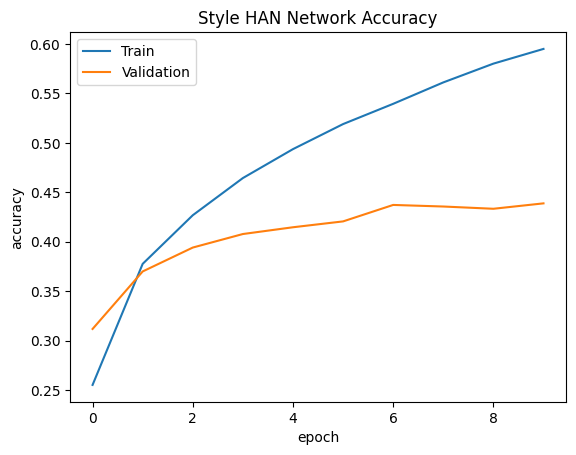

In [76]:
# summarize history for accuracy
plt.plot(average_accuracy_accross_kfold)
plt.plot(average_validation_accuracy_accross_kfold)
plt.title('Style HAN Network Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("outputs/style_han_network_acc.eps", format='eps')
plt.show()




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


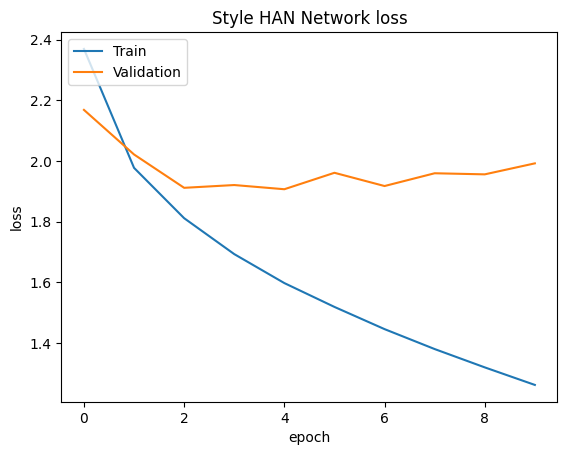

In [77]:
# summarize history for loss
plt.plot(average_loss_accross_kfold)
plt.plot(average_validation_loss_accross_kfold)
plt.title('Style HAN Network loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("outputs/style_han_network_loss.eps", format='eps')
plt.show()
